# Optimization script
This script evaluates the measurements on the system, updates the models and returns the next parameters based on the forecast context variable.
The script has to be executed at the beginning of each day, so that the next parameters are set to the RBC in simulation/rbc_3_1_2.py every day from 0 to 1 AM.During this period of time the control script will reset the SoC of the battery to 55%

## Import libs and set constants

In [2]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.insert(0,'..')
from mtfunc.helper import *
from mtfunc.datacqui import *
import safeopt
import pandas as pd
import time
import tensorflow as tf
hour=60
day=24*hour
C=96 #kWh
soc_lim=np.array([30,80])
p_bat_lim=1*C #1C 
p_std=p_bat_lim
soc_std=soc_lim[1]-soc_lim[0]# do not change unless necesary
soc_ref=(soc_lim[1]+soc_lim[0])/2
dt=1
optfolder='opt_recovery'

['..', '/Users/adrianpaeckelripoll/rbc-parameter-tuning/experiment_codes', '/opt/anaconda3/envs/env1/lib/python39.zip', '/opt/anaconda3/envs/env1/lib/python3.9', '/opt/anaconda3/envs/env1/lib/python3.9/lib-dynload', '', '/opt/anaconda3/envs/env1/lib/python3.9/site-packages', '/opt/anaconda3/envs/env1/lib/python3.9/site-packages/IPython/extensions', '/Users/adrianpaeckelripoll/.ipython']
/Users/adrianpaeckelripoll/rbc-parameter-tuning/mtfunc   was appended to PYTHONPATH


## Define context forecast functions

In [6]:
#Import saved models
demand_10min_model=tf.keras.models.load_model('../saved_models/loss_10minpowerdev_convtd_powerdemand_dayweeksincos_4h')
demand_model=tf.keras.models.load_model('../saved_models/loss_demand_convtd_1dpowerdemand_Tfc_dayweeksincos_7w_ctxt/')
PV_model=tf.keras.models.load_model('../saved_models/s1PVpower_3conv')
#Acquire NEST data and preprocess it
def data_prepocess():
    #Sample time
    dt=hour
    #Forecast horizon
    STEPS=day//dt
    #Power baseline function
    def baseline_fun(data):
        order=12*hour/dt
        base_idx=signal.argrelmin(data.values,order=int(order))[0]
        mask=np.empty_like(data.values)
        mask[:]=np.nan
        bs=pd.Series(mask)
        bs.iloc[base_idx]=data.iloc[base_idx]
        bs=bs.ffill()
        bs=bs.bfill()
        return bs.mean()
    #Get input data for PV model from NEST
    PV=get_PV(dt=dt*60,d=9)
    #Get input data for demand model from NEST
    load=get_demand_fc_data(dt=dt*60,d=9)
    load.rename(columns={'power_bypass_ehub':'power_load'},inplace=True)
    data=pd.concat([pd.DataFrame({'power_pv':PV}),load],axis=1)
    data['power_demand']=data.power_load+data.power_pv
    data.loc[data.power_demand.values<0,'power_demand']=0    
    data.reset_index(inplace=True)
    #Remove baseline
    for i in range(len(data)-STEPS):
        data.loc[i+STEPS,'bs']=baseline_fun(data.power_demand.iloc[i:i+STEPS])
    data.set_index('timestamp',inplace=True,drop=True)
    data.bs=data.bs.bfill()
    shft=data.reset_index()[data.index.strftime('%A')=='Monday'].index[0]
    #Generate periodic sin/cos time signals
    print('Cos/sin week start on: ',data.index[shft].strftime('%A'))
    data=data.reset_index(drop=False)
    data.power_demand=data.power_demand-data.bs
    data.loc[data.power_demand.values<0,'power_demand']=0
    data['time']=data.index*dt-shft*dt
    data['day_sin']=np.sin(2*np.pi*data.time/day)
    data['day_cos']=np.cos(2*np.pi*data.time/day)
    data['week_sin']=np.sin(2*np.pi*data.time/day/7)
    data['week_cos']=np.cos(2*np.pi*data.time/day/7)
    data=data.drop(columns=['time']) 
    #Shift all signals but the load power
    data[['outside_temperature_fc','day_sin','day_cos','week_sin','week_cos']]=data[['outside_temperature_fc','day_sin','day_cos','week_sin','week_cos']].shift(-day//dt)
    data=data.set_index('timestamp',drop=True)
    return data.dropna()
#Generate demand power forecast
def demand_fc(model=demand_model,short_term=demand_10min_model):
    #Use both CNNs of the demand model to generate forecast
    dt=60
    dt10min=10    
    #Get data and preprocess it
    data=data_prepocess().reset_index()
    #Set conv widths
    conv_width_demand=7*day//dt
    conv_width_10=4*hour//dt10min
    STEPS=day//dt
    Tin=conv_width_demand+STEPS-1
    #Set inputs of both CNN
    inputs_demand=['power_demand','outside_temperature_fc',
        'day_sin','day_cos','week_sin','week_cos']        
    inputs_demand_10min=['power_demand',
        'day_sin','day_cos','week_sin','week_cos']  
    #Predict hourly demand
    p_hour=model.predict(data.loc[:,inputs_demand].values[None,:,:]).flatten()
    data.loc[len(data)-len(p_hour):,'power_demand']=p_hour
    data=data.set_index('timestamp').resample(f'{dt10min}T').mean().interpolate().reset_index()
    #Predict 10 min demand deviation
    p_dev=short_term.predict(data.loc[:,inputs_demand_10min].values[None,:,:]).flatten()
    data.loc[len(data)-len(p_dev):,'power_dev']=p_dev
    data['power_demand']=data.power_demand-data.power_dev
    data.loc[data.power_demand<0,'power_demand']=0
    data=data[1*day//dt10min:].set_index('timestamp').resample(f'{dt}T').mean().interpolate()
    data.power_demand=data.power_demand+data.bs.iloc[-2*day//dt:].mean()
    return data.iloc[-day//dt:]
#Generate PV power forecast
def pv_fc(model=PV_model):
    dt=hour
    #Get input data
    data=get_weather_fc(dt=dt*60,d=2)
    data[['outside_temperature_fc','rh_outside_fc','global_radiation_fc']]=data[['outside_temperature_fc','rh_outside_fc','global_radiation_fc']].shift(-day//dt)
    inputs_PV=['global_radiation_fc', 'outside_temperature_fc', 'rh_outside_fc',
       'solar_elevation', 'solar_azimuth']    
    data=data.dropna()
    #Predict PV power 
    p_pv=model.predict(data.loc[:,inputs_PV].values[None,:,:]).flatten()
    data.loc[len(data)-len(p_pv):,'power_pv']=p_pv
    return data.iloc[-day//dt:]
#Load forecast
def load_generator():
    dt=60
    #Get PV power forecast
    p_pv=pv_fc()['power_pv']
    #Get demand power forecast
    p_d=demand_fc()['power_demand']
    data=pd.concat([p_pv,p_d],axis=1)
    #Calculate load power forecast
    data['power_load']=data.power_demand-data.power_pv
    return data
#Calculate context variable forecast
def data_context(data):
    dt=60
    data[['power_load','power_pv','power_demand']].plot()
    data['power_load_']=np.clip(data.power_load,-p_bat_lim,p_bat_lim)
    data['pp']=data.power_load_[data.power_load>0]
    data.pp=data.pp.fillna(0)
    data['pm']=data.power_load_[data.power_load<=0]
    data.pm=data.pm.fillna(0)
    data.drop(columns='power_load_',inplace=True)
    data['e_dis']=data.pp.sum()/hour*dt/C #kWh
    data['e_char']=data.pm.sum()/hour*dt/C #kWh
    data.e_char=data.e_char.abs()
    data.e_char=np.clip(data.e_char,0,np.diff(soc_lim)[0]/100)
    return data
def context_fc():
    return data_context(load_generator())['e_char'].values[0]

# Initialize CSBO

In [112]:
#Set initial parameters, metrics and context
past_ctxt=np.atleast_2d([0])
past_par=np.array([[0.5,-0.5]])
past_prf=np.array([[-4.34,0.4]])

In [90]:
import safeopt
import GPy
# Experimental HPs
hp=get_data('../simulation/hps/ESRBC/hyperpar_loglike2_b2.npy')
Vz=hp[0]
Lz=hp[1]
Vq=hp[2]
Lq=hp[3]
Vqs=hp[4]
Lqs=hp[5]
beta=hp[6]
Lctxt_z=hp[7]
Lctxt_q=hp[8]
Lctxt_qs=hp[9]
print(hp)
noise_cst = 2e-1#cst_mmnt_noise.mean()/10
noise_const =5e-4

# Bounds on the inputs variable
bounds = [(0., 4.),(-1,1)]
parameter_set = safeopt.linearly_spaced_combinations(bounds, 200)
parameter_set=parameter_set[parameter_set[:,0]>=-parameter_set[:,1]]
# Define kernels
cost_kernel_ = GPy.kern.RBF(input_dim=len(bounds), variance=Vz, lengthscale=[Lz[0],Lz[1]], ARD=True,active_dims=[0,1])
cost_context_kernel=GPy.kern.RBF(input_dim=1, variance=1, lengthscale=Lctxt_z, ARD=True,active_dims=[2],name='context')
cost_kernel=cost_kernel_*cost_context_kernel

const_kernel_=GPy.kern.RBF(input_dim=len(bounds), variance=Vq, lengthscale=[Lq[0],Lq[1]], ARD=True,active_dims=[0,1])
const_context_kernel=GPy.kern.RBF(input_dim=1, variance=1, lengthscale=Lctxt_q, ARD=True,active_dims=[2],name='context')
const_kernel=const_kernel_*const_context_kernel

# safeconst_kernel_=GPy.kern.RBF(input_dim=len(bounds), variance=Vqs, lengthscale=[Lqs[0],Lqs[1]], ARD=True,active_dims=[0,1])
# safeconst_context_kernel=GPy.kern.RBF(input_dim=1, variance=1, lengthscale=Lctxt_qs, ARD=True,active_dims=[2],name='context')
# safeconst_kernel=safeconst_kernel_*safeconst_context_kernel


context=np.array([[past_ctxt[0]]])
x0=np.hstack([past_par[0,:],past_ctxt[0]])
x0=x0[None]
y0= np.atleast_2d(past_prf[0,:])
print(x0,y0)
cost_gp = GPy.models.GPRegression(x0,y0[:,0,None], cost_kernel, noise_var=noise_cst)
const_gp= GPy.models.GPRegression(x0,y0[:,1,None], const_kernel, noise_var=noise_const)
# safeconst_gp= GPy.models.GPRegression(x,y0[:,2,None], safeconst_kernel, noise_var=noise_safeconst)
gp=[cost_gp,const_gp]
# The optimization routine
opt_ucb=safeopt.SafeOpt(gp,parameter_set=parameter_set,fmin=[-np.inf,-0], threshold=np.array([-np.inf,-np.inf]),beta=beta,num_contexts=1)
x_next=np.round(opt_ucb.optimize(ucb=True,context=context),3)  
#Use this parameters
print('next par: ',x_next)


[3.4225000000000003 list([0.355, 0.17]) 0.07896100000000002
 list([0.412, 0.231]) 0.042435999999999995 list([0.181, 0.167]) 2 0.3
 0.824 0.67]
[[ 0.5 -0.5  0. ]] [[-4.34  0.4 ]]
This is local package in rbc-parameter-tuning
next par:  [ 0.543 -0.357]
opt_recovery/CSBO2_2022_03_09_0437


0

In [74]:
np.vstack([past_par,x_next])
save_data(opt_ucb.gps,'CSBO2',folder=optfolder,pick=True)
save_data(past_par,'past_par',folder=optfolder)
save_data(past_prf,'past_prf',folder=optfolder)
save_data(past_ctxt,'past_ctxt',folder=optfolder)

array([[ 0.5  , -0.5  ],
       [ 0.543, -0.357]])

#  Optimization

In [75]:
P1=188 # buy price in euro/MWh
P2=170
P3=115
S1=53 #sell price in euro/MWh
B1=0
#Define the start and end date for the measurement evaluation. Change the date every day to the start and end date of the experiment with some parameters.
#This is done in case the same parameters are used for multiple days due to failed experiments.
sdate='2022-03-31 1:00'
fdate='2022-03-31 23:59'
#Define el. price function
def price_fun(k=None):
    price=DemandSignal(day,1,1)
    price.step_signal([0.29,0.33,0.54,0.71,0.87],[P3,P2,P1,P2,P1,P3])
    if k is None:
        return price.signal
    else:
        return price.signal[k]
# Get load power data from the visuallizer
def get_power_data():
    power_data=get_resampled(dt=60,d=1)
    power_data['power_pv']=get_PV(dt=60,d=1)
    power_data['power_demand']=power_data.power_pv+power_data.power_bypass_ehub
    return power_data    
 
def get_perf(df,par=None,p_bat_label='PT200',p_load_label='p_avg',dt=dt,T=1,sdate=sdate,fdate=fdate):
    #Calculate performance metric 
    #par: paramters on which to calculate the metric
    #sdate: start date 
    #fdata: end date
    T=int(T*day*23/24)
    data=df[[p_bat_label,p_load_label,'SoC']].copy()
    if par is not None :
        data=data.loc[(df.par0==par[0]) & (df.par1==par[1])]
    data=data.resample(f'{dt}T').mean().interpolate().dropna()
    data=data.loc[sdate:fdate]
    data.plot()
    p_bat=data[p_bat_label].values
    p_load=data[p_load_label].values
    def r_price_sell_fun():    
        def price_sell_map_fun(p_bat,p_load,f_buy,f_sell,f_bat):
            if (-p_bat<=p_load)&(p_load>=0):
                return -p_bat*f_buy + max(0,np.sign(-p_bat))*p_bat*f_bat
            if (-p_bat>p_load)&(p_load>=0):
                return -f_sell*(p_bat+p_load)+f_buy*p_load + max(0,np.sign(-p_bat))*p_bat*f_bat
            if (-p_bat<=p_load)&(p_load<0):
                return -f_buy*(p_bat+p_load)+f_sell*p_load + max(0,np.sign(-p_bat))*p_bat*f_bat
            if (-p_bat>p_load)&(p_load<0):
                return -p_bat*f_sell + max(0,np.sign(-p_bat))*p_bat*f_bat
            else: return 0
        return np.array(list(map(price_sell_map_fun,p_bat,p_load,price_fun(),S1*np.ones(T),B1*np.ones(T))))/hour*dt*1e-3 # [euro]
    return r_price_sell_fun().sum()
# Get mmnt data from experiment storage folder
def get_mmnt(last=None):
    dir_path='/Users/adrianpaeckelripoll/rbc-parameter-tuning/experiment/ESRBC_exp0/df*'
    path_list=sorted( glob.glob(dir_path), key = os.path.getctime)
    print(len(path_list))
    df_list=[]
    if last is None:
        last=len(path_list)    
    for pth in path_list[-last:]:
        df_list.append(get_data(pth,npy=False))
    df=pd.concat(df_list,axis=0) 
    df.timestamp=pd.to_datetime(df.timestamp)
    df=df.set_index('timestamp',drop=True)
    df.sort_index(inplace=True)
    return df
#Get performance metric
def get_performance(par,sdate=sdate,fdate=fdate,last=300):
    data=get_mmnt(last=last)
    print(data.par0[-1],data.par1[-1],data.index[0],data.index[-1])
    data.par0=np.round(data.par0,3)
    data.par1=np.round(data.par1,3)    
    return get_perf(data,par)
#Get constraint metric
def get_constraint(par,norm=True):
    dt=1
    data=get_mmnt(last=None)
    data.par0=np.round(data.par0,3)
    data.par1=np.round(data.par1,3) 
    if par is not None :
        data=data.loc[(data.par0==par[0]) & (data.par1==par[1])]
    data=data.resample(f'{dt}T').mean().interpolate().dropna()
#     data.plot()
    if norm:
        return (data.loc[pd.Timestamp(fdate)].SoC-55)/soc_std
    else:
        return data.loc[pd.Timestamp(fdate)].SoC
#Get past context    
def get_past_ctxt():
    data=get_resampled(dt=60,d=1)
    data.columns=['power_load']
    data['power_load_']=np.clip(data.power_load,-p_bat_lim,p_bat_lim)
    data['pm']=data.power_load_[data.power_load<=0]
    data.pm=data.pm.fillna(0)
    data.drop(columns='power_load_',inplace=True)
    return np.clip(data.pm.abs().sum()/hour*dt/C,0,np.diff(soc_lim)[0]/100)   
# path_par=sorted( glob.glob('opt_recovery/past_par*'), key = os.path.getctime)
# past_par=get_data(path_par[-1])
# print(get_performance( past_par[-1]) )
# print(get_constraint(past_par[-1],norm=False))

This is local package in rbc-parameter-tuning
4535
0.965 -0.377 2022-03-26 22:17:43 2022-04-01 00:39:07
4535
past par: [ 0.965 -0.377]
perf: 3.2130494266473644 cons: 0.4040000000000001 context: 0.0
2022-03-31 00:51:23 2022-04-02 00:51:23


 /opt/anaconda3/envs/env1/lib/python3.9/site-packages/pandas/core/indexing.py:719: FutureWarning:Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


Cos/sin week start on:  Monday
context forecast: 0.05619941186912188
next_par: [ 0.824 -0.387]
[[ 0.5   -0.5  ]
 [ 0.543 -0.357]
 [ 0.563 -0.216]
 [ 0.824 -0.417]
 [ 0.362 -0.286]
 [ 0.241 -0.196]
 [ 0.08  -0.075]
 [ 0.683 -0.337]
 [ 0.764 -0.528]
 [ 0.764 -0.548]
 [ 0.844 -0.839]
 [ 0.     0.327]
 [ 0.784 -0.417]
 [ 0.965 -0.377]
 [ 0.824 -0.387]]
[[-4.34        0.4       ]
 [ 2.28820531  0.4       ]
 [ 1.10378713  0.08      ]
 [ 2.99945759  0.03833333]
 [-2.53617525  0.37      ]
 [-2.83467767  0.32333333]
 [-3.28658513  0.4       ]
 [-0.24444916  0.27      ]
 [ 1.55495394  0.07      ]
 [-1.83074445  0.4       ]
 [-2.5598848   0.37      ]
 [ 6.31830983 -0.4       ]
 [ 8.79219133  0.4       ]
 [ 3.21304943  0.404     ]]
[[0.        ]
 [0.5       ]
 [0.5       ]
 [0.5       ]
 [0.        ]
 [0.00052957]
 [0.        ]
 [0.5       ]
 [0.19885399]
 [0.5       ]
 [0.5       ]
 [0.07043243]
 [0.07043243]
 [0.        ]]


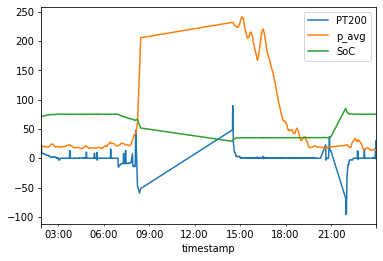

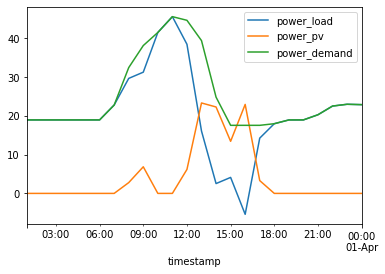

In [23]:
path_par=sorted( glob.glob('opt_recovery/past_par*'), key = os.path.getctime)
path_ctxt=sorted( glob.glob('opt_recovery/past_ctxt*'), key = os.path.getctime)
path_prf=sorted( glob.glob('opt_recovery/past_prf*'), key = os.path.getctime)
path_CSBO=sorted( glob.glob('opt_recovery/CSBO2*'), key = os.path.getctime)
if len(path_par)==0:
    print('Not initilized')

past_ctxt=get_data(path_ctxt[-1])
past_par=get_data(path_par[-1])
past_prf=get_data(path_prf[-1])
gps=get_data(path_CSBO[-1],pick=True)
# Bounds on the inputs variable
bounds = [(0., 4.),(-1,1)]
parameter_set = safeopt.linearly_spaced_combinations(bounds, 200)
parameter_set=parameter_set[parameter_set[:,0]>=-parameter_set[:,1]]
opt_ucb=safeopt.SafeOpt(gps,parameter_set=parameter_set,fmin=[-np.inf,-0], threshold=np.array([-np.inf,-np.inf]),beta=0.5,num_contexts=1)

prf=get_performance(past_par[-1])
cnst=get_constraint(past_par[-1])
ctxt=get_past_ctxt()
past_ctxt=np.vstack([past_ctxt,[ctxt]])
past_prf=np.vstack([past_prf,[prf,cnst]])
print('past par:',past_par[-1])
print('perf:',prf,'cons:',cnst,'context:',ctxt)
opt_ucb.add_new_data_point(past_par[-1],np.atleast_2d([prf,cnst]),context=np.atleast_2d([ctxt]))
ctxt_fc=context_fc()
print('context forecast:',ctxt_fc)
next_par=np.round(opt_ucb.optimize(ucb=True,context=ctxt_fc),3)
print('next_par:',next_par)
past_par=np.vstack([past_par,next_par])

print(past_par)
print(past_prf)
print(past_ctxt)

#### Save data only in case parameter experiment finished without errors.
Process: (initialize)-loop[check perf,cnst,ctxt,ctxt_fc-->save parameters for next iteration]

In [ ]:
save_data(opt_ucb.gps,'CSBO2',folder=optfolder,pick=True)
save_data(past_par,'past_par',folder=optfolder)
save_data(past_prf,'past_prf',folder=optfolder)
save_data(past_ctxt,'past_ctxt',folder=optfolder)

# Evaluation
Replace ../optimization_sim/NL_opt/exp_opt_par_3_1_2_2022_04_06_2205.npy with new optimal parameters

In [95]:
path_par=sorted( glob.glob('opt_recovery/past_par*'), key = os.path.getctime)
path_ctxt=sorted( glob.glob('opt_recovery/past_ctxt*'), key = os.path.getctime)
path_prf=sorted( glob.glob('opt_recovery/past_prf*'), key = os.path.getctime)
path_CSBO=sorted( glob.glob('opt_recovery/CSBO2*'), key = os.path.getctime)
if len(path_par)==0:
    print('Not initilized')

past_ctxt=get_data(path_ctxt[1])[:9]
past_par=get_data(path_par[1])[:9]
past_prf=get_data(path_prf[1])[:9]
gps=get_data(path_CSBO[-1],pick=True)
# Bounds on the inputs variable
bounds = [(0., 4.),(-1,1)]
parameter_set = safeopt.linearly_spaced_combinations(bounds, 200)
parameter_set=parameter_set[parameter_set[:,0]>=-parameter_set[:,1]]
opt_ucb=safeopt.SafeOpt(gps,parameter_set=parameter_set,fmin=[-np.inf,-0], threshold=np.array([-np.inf,-np.inf]),beta=0.5,num_contexts=1)

This is local package in rbc-parameter-tuning


In [115]:
opt_par=get_data('../optimization_sim/NL_opt/exp_opt_par_3_1_2_2022_04_06_2205.npy')[:9]
opt_cst=get_data('../optimization_sim/NL_opt/exp_opt_cst_3_1_2_2022_04_06_2205.npy')[:9]
len(opt_par)

9

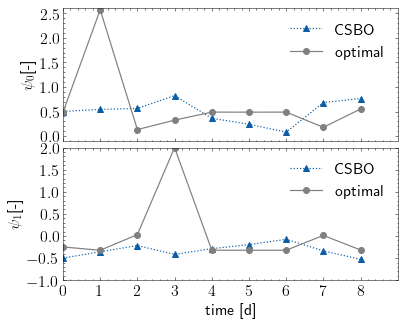

In [164]:
height2=5
# past_par=past_par[:-1]
with plt.style.context('science'):
    plt.rcParams.update({'font.size': 16})                        
    err=25e-2
    iterations=len(past_par)
    fig,ax=plt.subplots(2,sharex=True,figsize=(6,height2))

    ax[0].plot(range(iterations),past_par[:,0],':^',label='CSBO',linewidth=1.2)
    ax[0].plot(np.arange(len(opt_par)),opt_par[:,0],'-o',label='optimal',linewidth=1.2,color='grey')    
    ax[1].plot(range(iterations),past_par[:,1],':^',label='CSBO',linewidth=1.2)
    ax[1].plot(np.arange(len(opt_par)),opt_par[:,1],'-o',label='optimal',linewidth=1.2,color='grey')      
    ax[0].set_xticks(np.arange(0,iterations,2))
    ax[0].set_ylim([-0.1,2.6])
    ax[1].set_ylim([-1,2])
    ax[0].set_ylabel(r'$\psi_0$[-]')
    ax[0].legend()    
    ax[1].set_ylabel(r'$\psi_1$[-]')
    ax[1].legend()
    ax[0].set_xticks(np.arange(0,iterations,1))    

    plt.xlabel('time [d]')
    plt.xlim([-0,iterations])
    plt.subplots_adjust(hspace=0.05)
plt.savefig(f'../fig_scripts/experiment/par_exploration.pdf')
plt.show()
    

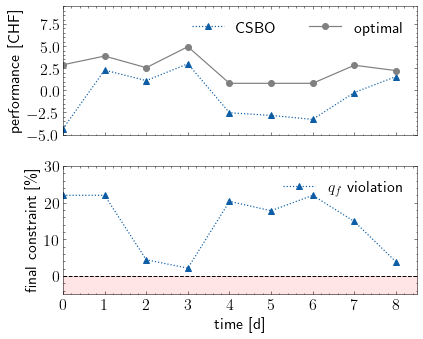

In [201]:
with plt.style.context('science'):
    plt.rcParams.update({'font.size': 16})
    err=25e-2
    fig,ax=plt.subplots(2,sharex=True,figsize=(6,height2))
    
    ax[0].plot(range(iterations),past_prf[:,0],':^',label='CSBO',linewidth=1.2)
    ax[0].plot(np.arange(len(opt_par)),-opt_cst[:],'-o',label='optimal',linewidth=1.2,color='grey')          
    ax[1].plot(range(iterations),past_prf[:,1]*55,':^',label='$q_f$ violation',linewidth=1.2)
    ax[1].hlines(0,0,iterations,'k',linestyles='--')
    ax[1].fill_between(range(10),y1=0,y2=-20,color='red',alpha=0.1)
#     ax[1].plot(range(iterations),rnd_opt_cst[:iterations,1],':h',label='Optimal',linewidth=1.2,color='grey')
    ax[0].set_xticks(np.arange(0,iterations,1))
    ax[0].set_ylim([-5,9.5])
    ax[1].set_ylim([-5,30])
    ax[0].set_ylabel(r'performance [CHF]')
    ax[0].legend(ncol=2)    
    ax[1].set_ylabel(r'final constraint [\%]')
    ax[1].legend(loc='upper right')

    plt.xlabel('time [d]')
    plt.xlim([-0,8.5])
    plt.subplots_adjust(hspace=0.02)
    plt.tight_layout()
plt.savefig(f'../fig_scripts/experiment/exp_evaluation.pdf')
plt.show()